In [1]:
import numpy as np
import os
import pandas as pd
import time
import math

# package for io 
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers import tiff_reader, OmeTiffReader

from CustomFunctions.track_functions import segment_caax_tracks_iSIM, segment_caax_tracks_iSIM_20x, segment_caax_tracks_iSIM_visiview_halfsize
import itertools
from skimage import measure as skmeasure
import datetime


from skimage.morphology import disk
from skimage.filters import median, gaussian


# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)
    

def mygrouper(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))
    


def get_intensity_features(img, seg):
    features = {}
    input_seg = seg.copy()
    input_seg = (input_seg>0).astype(np.uint8)
    input_seg_lcc = skmeasure.label(input_seg)
    for mask, suffix in zip([input_seg, input_seg_lcc], ['', '_lcc']):
        values = img[mask>0].flatten()
        if values.size:
            features[f'intensity_mean{suffix}'] = values.mean()
            features[f'intensity_std{suffix}'] = values.std()
            features[f'intensity_1pct{suffix}'] = np.percentile(values, 1)
            features[f'intensity_99pct{suffix}'] = np.percentile(values, 99)
            features[f'intensity_max{suffix}'] = values.max()
            features[f'intensity_min{suffix}'] = values.min()
        else:
            features[f'intensity_mean{suffix}'] = np.nan
            features[f'intensity_std{suffix}'] = np.nan
            features[f'intensity_1pct{suffix}'] = np.nan
            features[f'intensity_99pct{suffix}'] = np.nan
            features[f'intensity_max{suffix}'] = np.nan
            features[f'intensity_min{suffix}'] = np.nan
    return features



def dist_f(a1, b1, c1, a2, b2, c2):

    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

# Function to find Angle
def angle_distance(a1, b1, c1, a2, b2, c2):
    a1,b1,c1 = [a1,b1,c1]/np.linalg.norm([a1,b1,c1])
    a2,b2,c2 = [a2,b2,c2]/np.linalg.norm([a2,b2,c2])
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

In [2]:
############################# RUN TRACKMATE TRACKING ON SEGMENTED IMAGES ##################################

In [23]:
#### get together all images on the NAS #########

ip = 0.1613 #um / pixel  #0.1613 40xW  #0.3226 20xW
step = 0.5 # um

#### directory info
bigdir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/'
foldlist = ['20230727',
           '20230801',
           '20230802',
           '20230803']
savedir = 'D:/Aaron/Data/Galvanotaxis/Tracking_Images/'


for f in foldlist:
    ims = [x.split('.companion')[0] for x in os.listdir(bigdir+f+'/') if 'companion' in x]
    for i in ims:
        #make the savedir if it doesn't exist
        if not os.path.exists(savedir+i+'/'):
            os.makedirs(savedir+i+'/')
        
        #get list of all individual time point images for this big image
        imagelist = [x for x in os.listdir(bigdir+f+'/') if i in x and 'Reflected' in x]
        #sort the list by time
        imagelist = sorted(imagelist, key=lambda x: int("".join([i for i in x if i.isdigit()])))
        
        results = []
        if __name__ ==  '__main__':
        # use multiprocessing to perform segmentation and x,y,z determination
            pool = multiprocessing.Pool(processes=60)
            for t, im in enumerate(imagelist):
                imname = bigdir + f+ '/' + im
                pool.apply_async(segment_caax_tracks_iSIM_visiview_halfsize, args=(imname, ip, step, t, ), 
                                 callback=collect_results)
            pool.close()
            pool.join()
            print(f'Finished segmenting {i}')



        #organize the semented frames into a segmented stack
        segmented_img = np.zeros((len(imagelist),
                                 results[0][3][-3],
                                 results[0][3][-2],
                                 results[0][3][-1]))
        for r in results:
            fr = r[2]
            segmented_img[fr,:,:,:] = r[1]    

        #covert to more compact data type
        segmented_img = segmented_img.astype(np.uint8)

        #save the segmented image
        OmeTiffWriter.save(segmented_img, savedir+i+'/'+i+'_segmented.ome.tiff', dim_order = "TZYX", overwrite_file=True)


        #save the skimage region props
        df = pd.DataFrame()
        for d in results:
            df = df.append(pd.DataFrame(d[0], columns = ['cell', 
                         'frame', 'z_min', 'y_min', 
                        'x_min','z_max', 'y_max', 'x_max',
                       'z', 'y', 'x', 'z_range',
                       'area', 'convex_area', 'extent',
                       'minor_axis_length', 'major_axis_length',
                        'intensity_avg', 'intensity_max', 'intensity_std']))
        df = df.sort_values(by = ['frame','cell'])
        df.to_csv(savedir+i+'/'+i+'_region_props.csv')


        


//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv5_w2GFP-Cy5-UVEpi-Reflected_t7.ome.tf2
//10.158.28.37/ExpansionHom

Finished segmenting 20230727_488EGFP-CAAX_640actin-halotag_Galv2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-h

Finished segmenting 20230727_488EGFP-CAAX_640actin-halotag_Galv3
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random5_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random5_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random5_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random5_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random5_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random5_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-h

Finished segmenting 20230727_488EGFP-CAAX_640actin-halotag_Random4
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin

Finished segmenting 20230727_488EGFP-CAAX_640actin-halotag_Galv4
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230727/20230727_488EGFP-CAAX_640actin-halotag_Galv1

Finished segmenting 20230727_488EGFP-CAAX_640actin-halotag_Random1
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random4_w2GF

Finished segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random5_w2GFP-Cy5

Finished segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv5
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random3_w2GFP-Cy5

Finished segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv1
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv2_w2GFP-Cy5-UVEpi-Reflect

Finished segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Galv6_w2GFP-Cy5-UVEpi-Refle

Finished segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230801/20230801_488EGFP-CAAX_640SPY650-DNA_Random1_w2GFP-C

Finished segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv4_w2

Finished segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-h

Finished segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random5
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin

Finished segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin

//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t7.ome.tf2
//10.158.28.37/ExpansionHom

Finished segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230802/20230802_488EGFP-CAAX_640actin-halotag_Galv2

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv6

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random1_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-h

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random5
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Galv3_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Gal

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random4_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random3_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-h

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t1.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t2.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t3.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t4.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t5.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-halotag_Random2_w2GFP-Cy5-UVEpi-Reflected_t6.ome.tf2
//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/20230803/20230803_488EGFP-CAAX_640actin-h

Finished segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5


In [5]:
folder_fl+u

'D:/Aaron/Data/Galvanotaxis_Longtracks/Tracking_Images/20230907_488EGFP-CAAX_3mA_Galv_1'

In [2]:
############### SEGMENT AND SAVE CELLS ################################

############## alignment by chemical gradient ###################

from scipy.spatial import KDTree, distance
from itertools import groupby
from operator import itemgetter
from scipy import interpolate
import re
from aicsimageio.readers.bioformats_reader import BioformatsReader

#import the cell segmentation and rotation function
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# import_path = 'C:/Users/Aaron/Documents/PythonScripts/CustomFunctions'
# sys.path.insert(1, import_path)
from CustomFunctions.segment_cells_iSIM import segment_cells_rotafter_VV

from CustomFunctions.persistance_activity import get_pa


# path to folder(s)
folder_fl = 'D:/Aaron/Data/Galvanotaxis/Tracking_Images/'
filelist_fl = [f for f in os.listdir(folder_fl) if '.' not in f]
savedir = 'D:/Aaron/Data/Galvanotaxis/Processed_Data/'
raw_dir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 Galv/'

#parameters for segmentation
xy_buffer = 25 #pixels
z_buffer = 7 #pixels
sq_size = 250 #pixels
xyres = 0.1613 #um / pixel
zstep = 0.5 # um
interval = 15
intthresh = 120 #for the half shrunken images, determined by manually crossreferencing

# u = filelist_fl[11]


for u in filelist_fl:

    ################## align trackmate data with region props data ################
    rpcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("region_props.csv")][0]
    rp = pd.read_csv(folder_fl + u + '/' + rpcsv, index_col = 0)
    tmcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("TrackMateLog.csv")][0]
    tm = pd.read_csv(folder_fl + u+ '/' + tmcsv)
    #fix trackmate columns to get names right and units in microns
    tm['x'] = tm.POSITION_X*xyres
    tm['y'] = tm.POSITION_Y*xyres
    tm['z'] = tm.POSITION_Z*zstep
    #make kdtree and query with trackmate log
    kd = KDTree(rp[['frame','x','y','z']].to_numpy())
    dd, ii = kd.query(tm[['FRAME','x','y','z']])
    df_track = pd.concat([tm.drop(columns=['POSITION_X','POSITION_Y','POSITION_Z']), 
                        rp.iloc[ii].drop(columns=['frame','x','y','z', 'cell']).reset_index(drop=True)], axis=1)
    df_track = df_track.rename(columns={'TRACK_ID':'cell', 'FRAME':'frame'})
    #sort by cell and frame
    df_track = df_track.sort_values(['cell','frame'])



    # #read in image and tracking data
    image_name = u
    direct = folder_fl+u+'/'
    test = [x for x in os.listdir(direct+'/') if '.tif' in x][0]
    # currentim = folder_fl+filelist_fl[u]+'/'+ filelist_fl[u] + '_MMStack_Pos0.ome.tif'
    currentim = direct+'/'+ test
    im_temp_whole = tiff_reader.TiffReader(currentim)
    #double shape because it was halved
    imshape = [2*x for x in im_temp_whole.shape[1:]]


    #############find distance travelled##################
    longdistmatrix = distance.pdist(df_track[['x','y','z']])
    shortdistmatrix = distance.squareform(longdistmatrix)
    shortdistmatrix = np.array(shortdistmatrix)
    dist = pd.Series([], dtype = 'float64')
    for count, i in enumerate(shortdistmatrix):
        if count == 0:
            temp = pd.Series([0])
            dist = dist.append(temp, ignore_index=True)
        else:
            temp = pd.Series(shortdistmatrix[count,count-1])
            dist = dist.append(temp, ignore_index=True)
    df_track = df_track.reset_index(drop = True)
    df_track['dist'] = dist
    #first rows that have super long distances from previous cell, so set them to 0
    df_track.loc[df_track.groupby('cell').head(1).index,'dist'] = 0

    ############ replace unrealistic jumps in distance ##############
    for x in df_track[df_track.dist>4].index.values:
        df_track['dist'][x] = df_track.dist.mean()

    ############## find euclidean distance #############
    euclid = pd.DataFrame([])
    for i, cell in df_track.groupby('cell'):
        FL = cell.iloc[[0,-1]]
        euc_dist = distance.pdist(FL[['x','y','z']])
        euclid = euclid.append({'cell':cell.cell.iloc[0], 'euc_dist':euc_dist[0]}, ignore_index = True)
    cellsmorethan = euclid.loc[euclid['euc_dist']>, 'cell']
    df_track = df_track[df_track.cell.isin(cellsmorethan)]

    #     ########remove "slow"/dead cells############
    #     #sum distances
    #     df_track_distsums = df_track.groupby('cell').sum()
    #     df_track_distsums = df_track_distsums.add_suffix('_sum').reset_index()

    #     #grab only cells with sums above a threshold distance
    #     cellsmorethan = df_track_distsums.loc[df_track_distsums['dist_sum']>5, 'cell']
    #     df_track = df_track[df_track.cell.isin(cellsmorethan)]


    ##########remove small things that are likely dead cells or parts of cells###########
    df_track = df_track[df_track['area'] > 15000 ]

    ######### remove cells with low caax intensity ###########
    df_track = df_track[df_track['intensity_avg'] > intthresh ]
    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)


    ########remove edge cells############
    #only grab rows that aren't zero in z_min
    df_track = df_track.loc[df_track['x_min'] >8 ]
    df_track = df_track.loc[df_track['y_min'] >8 ]
    df_track = df_track.loc[df_track['z_min'] !=0 ]
    #remove rows where z_max matches z_range
    df_track = df_track.loc[df_track['x_max'] < int(imshape[-1]-4)]
    df_track = df_track.loc[df_track['y_max'] < int(imshape[-2]-4)]
    df_track = df_track.loc[df_track['z_max'] != (df_track['z_range']-1)]
    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)





    ######## remove cells that touch ###########    
    to_remove = []
    for i, cell in df_track.groupby('cell'):
        if i>0:
            changes = abs(cell['convex_area'].pct_change())
            largerthan = changes[changes>0.75]
            if largerthan.empty == False:
                to_remove.extend(largerthan.index.to_list())


            # changes = cell['convex_area'].diff()
            # largerthan = changes[changes>cell['convex_area']*0.333]
            # smallerthan = changes[changes<cell['convex_area']*-0.333]
            # print(largerthan.index,smallerthan.index)
            # #remove all frames of a cell after it contacts another cell
            # if largerthan.empty == False:
            #     for n in largerthan.index:
            #         to_remove.append(list(range(n, max(cell.index)+1)))
            # #remove all frames of a cell before it splits from another cell
            # if smallerthan.empty == False:
            #     for n in smallerthan.index:
            #         to_remove.append(list(range(cell.index[0], n-1)))
    # #remove duplicate indicies
    # to_remove = [j for x in to_remove for j in x]
    # to_remove = list(set(to_remove))
    #drop touching or splitting cells
    df_track = df_track.drop(to_remove)



    if df_track.empty == False:
        for i, cells in df_track.groupby('cell'):
            cells = cells.reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)
            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<3:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]
                    #segment the cell channel and get centroid
                    df = pd.DataFrame()
                    if __name__ ==  '__main__':
                        # use multiprocessing to perform segmentation and x,y,z determination
                        pool = multiprocessing.Pool(processes=60)
                        results = []
                        for t, row in cell.iterrows():
                            tdir = raw_dir +u.split('_')[0]+'/'
                            celldir = tdir + [x for x in os.listdir(tdir) if 'Reflected' in x and u in x and bool(int(re.search(r'_t(\d+)', x).group(1))==int(row.frame+1))][0]
                            structdir = tdir + [x for x in os.listdir(tdir) if 'Trans' in x and u in x and bool(int(re.search(r'_t(\d+)', x).group(1))==int(row.frame+1))][0]

                            xmincrop = int(max(0, row.x_min-xy_buffer))
                            ymincrop = int(max(0, row.y_min-xy_buffer))
                            zmincrop = int(max(0, row.z_min-z_buffer))

                            zmaxcrop = int(min(row.z_max+z_buffer, imshape[-3])+1)
                            ymaxcrop = int(min(row.y_max+xy_buffer, imshape[-2])+1)
                            xmaxcrop = int(min(row.x_max+xy_buffer, imshape[-1])+1)

                            pool.apply_async(segment_cells_rotafter_VV, args = (
                                celldir,
                                structdir,
                                row,
                                image_name,
                                savedir,
                                xyres,
                                zstep,
                                xmincrop, 
                                ymincrop, 
                                zmincrop,
                                xmaxcrop, 
                                ymaxcrop, 
                                zmaxcrop,
                                ),             
                                callback = collect_results)

                        pool.close()
                        pool.join()

                        print(f'Done segmenting {image_name} cell {cell.cell.iloc[0]}')

                    if any([x == None for x in results]):
                        ind = results.index(None)
                        if len(results[:ind])<3:
                            pass
                        else:
                            results = results[:ind]

                    #aggregate the dataframe
                    for d in results:
                        df = df.append(pd.DataFrame(d, columns = d.keys(), index=[0]))
                    df = df.sort_values(by = 'frame').reset_index(drop=True)



                    #make sure there are no gaps due to failed segmentations
                    if any(df.frame.diff()>1):
                        dft = df.reset_index(drop = True)
                        runs = list()
                        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                        for k, g in groupby(enumerate(dft['frame']), lambda ix: ix[0] - ix[1]):
                            currentrun = list(map(itemgetter(1), g))
                            list.append(runs, currentrun)
                        whichframes = np.array(max(runs, key=len), dtype=int)
                        pullrows = dft[dft.frame.isin(whichframes)]
                        df = dft.iloc[pullrows].reset_index(drop=True)


                    #add new distances from cropped image
                    #############find distance travelled##################
                    longdistmatrix = distance.pdist(df[['x','y','z']])
                    shortdistmatrix = distance.squareform(longdistmatrix)
                    shortdistmatrix = np.array(shortdistmatrix)
                    dist = pd.Series([], dtype = 'float64')
                    for count, i in enumerate(shortdistmatrix):
                        if count == 0:
                            tmp = pd.Series([0])
                            dist = dist.append(tmp, ignore_index=True)
                        else:
                            tmp = pd.Series(shortdistmatrix[count,count-1])
                            dist = dist.append(tmp, ignore_index=True)
                    df['dist'] = dist



                    ############## Bayesian persistence and activity #################
                    persistence, activity, speed = get_pa(df, interval)
                    df['persistence'] = np.concatenate([np.array([np.nan]*2), persistence])
                    df['activity'] = np.concatenate([np.array([np.nan]*2), activity])
                    df['speed'] = np.concatenate([np.array([np.nan]), speed])
                    df['avg_persistence'] = np.array([persistence.mean()]*(len(persistence)+2))
                    df['avg_activity'] = np.array([activity.mean()]*(len(activity)+2))
                    df['avg_speed'] = np.array([speed.mean()]*(len(speed)+1))


                    # ############# SEGMENT THE NUCLEUS ####################
                    # seg_nucleus = np.zeros(temp_im[:,1,:,:,:].shape).astype(bool)
                    # for t in range(temp_im.shape[0]):

                    #set the k order for interpolation to the max possible
                    if len(df)<6:
                        kay = len(df)-1
                    else:
                        kay = 5

                    #     seg_nucleus[t,:,:,:] = segment_nucleus(temp_im[t,1,:,:,:])
                    pos = df[['x','y','z']]
                    if bool(pos[pos.duplicated()].index.tolist()):
                        ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                        # if there is duplicate positions
                        dups = pos[pos.duplicated()].index.tolist()
                        pos_drop = pos.drop(dups, axis = 0)
                        if pos_drop.shape[0]<3:
                            traj = np.zeros([1,2,3])
                        else:
                            #get trajectories without the duplicates
                            tck, u = interpolate.splprep(pos_drop.to_numpy().T, k=kay)
                            yderv = interpolate.splev(u,tck,der=1)
                            traj = np.vstack(yderv).T
                            #re-insert duplicate row that was dropped
                            for d, dd in enumerate(dups):
                                traj = np.insert(traj, dd, traj[dd-1,:], axis=0)

                    else:
                        ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                        #no duplicate positions
                        #interpolate and get tangent at midpoint
                        tck, b = interpolate.splprep(pos.to_numpy().T, k=kay)
                        yderv = interpolate.splev(b,tck,der=1)
                        traj = np.vstack(yderv).T

                    #get the trajectory and the previous trajectory for each frame and 
                    #save as an individual dataframe for each cell and frame
                    for v, row in df.iterrows():
                        row = df.loc[v]
                        if v==0:
                            row['Prev_Trajectory_X'] = np.nan
                            row['Prev_Trajectory_Y'] = np.nan
                            row['Prev_Trajectory_Z'] = np.nan
                            row['Trajectory_X'] = traj[v,0]
                            row['Trajectory_Y'] = traj[v,1]
                            row['Trajectory_Z'] = traj[v,2]
                            row['Turn_Angle'] = np.nan
                            pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')
                        if v>0:
                            row['Prev_Trajectory_X'] = traj[v-1,0]
                            row['Prev_Trajectory_Y'] = traj[v-1,1]
                            row['Prev_Trajectory_Z'] = traj[v-1,2]
                            row['Trajectory_X'] = traj[v,0]
                            row['Trajectory_Y'] = traj[v,1]
                            row['Trajectory_Z'] = traj[v,2]
                            row['Turn_Angle'] = angle_distance(traj[v-1,0], traj[v-1,1], traj[v-1,2], traj[v,0], traj[v,1], traj[v,2])
                            pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 1
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 5
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 13
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 14
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 15
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 18
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 21


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 7


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 7
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 13
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 14
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 14
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 15
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 16
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 17
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 18
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 19
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 19
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 32
Done segment

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 1
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 1
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 5
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 7
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 7
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 8
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 10
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 11
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 13
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 15
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 22
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 22
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 23
Done segmenting 2

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 2
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 3
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 11
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 11
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 15
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 17
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 18


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 8


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 8
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 8
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 11
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 11
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 13
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 16
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 16
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 17
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 29
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 29
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 36


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv6 cell 3


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv6 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Galv6 cell 22


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 3


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 3
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 6
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 7
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 10
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 14
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 15
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 18
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 23
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 24
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 30
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 33
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 38
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random1 cell 42
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 2
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 2
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 3
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 3
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 3
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 11
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 13
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 29
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 33
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 35
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random2 cell 35


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 0
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 4
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 4
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 7
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 8
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 9
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 10
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 12
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 21
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 22
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random3 cell 27


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 0
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 0
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 2
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 4
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 4
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 4
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 5
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 7
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random4 cell 20


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 8
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 13
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 17
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 17
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 17
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 20
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 21
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 23
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 26
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 27
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 29
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 46
Done segmenting 20230727_488EGFP-CAAX_640SPY650-DNA_Random5 cell 46
Done segmenting 20230727_488EGFP-CAAX_640SPY650-D

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 6


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv1 cell 10


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 1


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 2
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 3
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 3
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 3
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 4
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 4
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 5
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 6
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 7
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 9
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 9
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 18
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 28
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv2 cell 28


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 13


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 15
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 18
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 25
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv3 cell 26


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 1


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 1
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 4
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 5
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 11
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 17
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 26
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 27
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv4 cell 36


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 4


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 6
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 20
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv5 cell 20


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv6 cell 1


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv6 cell 1
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Galv6 cell 24


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 0
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 1
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 1
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 6
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 9
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 14
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 15
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random1 cell 18
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Ra

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 1


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 9
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 14
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 15
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 15
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 23
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 25
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random2 cell 41


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 0
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 2
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 2
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 4
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 4
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 6
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 17
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 21
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 22
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random3 cell 24
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Rand

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 3


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 3
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 9
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 11
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 18
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 19
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 20
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 23
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 26
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random4 cell 26
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random5 cell 4


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random5 cell 7
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random5 cell 8


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 5


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 7
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 7
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 8
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 10
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 11
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 12
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 13
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 15
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 24
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_Random6 cell 24
Done segmenting 20230801_488EGFP-CAAX_640SPY650-DNA_R

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 1
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 2
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 3
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 27
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 27
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv1 cell 34


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 7
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 15
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 16
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 17
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 19
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 23
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 23
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 27
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 34
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv2 cell 40


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 3
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 7
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 7
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 10
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 15
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 26
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 27
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv3 cell 32
Done segmenting 20230802_488EGFP-CAAX_640a

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 0
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 1
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 4
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 7
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 7
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 8
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 14
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 16
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 18
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 18
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 18
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv4 cell 22
Done segmenting 20230802_488EGFP-CAAX_640

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv5 cell 5


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv5 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv5 cell 7


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 2
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 8
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 10
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Galv6 cell 15


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 10
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 10
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 10
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 13
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 14
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 14
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 16
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random1 cell 16
Done segme

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 3
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 7
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 8
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 8
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 8
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 9
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 10
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 13
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 14
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random2 cell 14
Done segmenting

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 2
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 20
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 21
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 22
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 22
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 22
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 25
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 25
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 26
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 28
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 32
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random3 cell 37
Done seg

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random4 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random4 cell 3
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random4 cell 4
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random4 cell 5
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random4 cell 6
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random4 cell 6


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random5 cell 10


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random5 cell 11
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random5 cell 12
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random5 cell 13
Done segmenting 20230802_488EGFP-CAAX_640actin-halotag_Random5 cell 15


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 0
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 1
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 15
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 15
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv1 cell 18


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv2 cell 3


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv2 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv2 cell 7


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 1


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 4
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 4
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 6
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 11
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv3 cell 20


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 6


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 7
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 7
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 9
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 14
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 19
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 19
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 30
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv4 cell 32


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 0
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 1
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 7
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 9
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 9
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 13
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv5 cell 13


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv6 cell 3


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv6 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv6 cell 12


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 5


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 7
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 15
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 19
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 19
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Galv7 cell 19


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 0
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 1
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 2
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 4
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random1 cell 16


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 4


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 8
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 9
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 13
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 13
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 13
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 15
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random2 cell 20


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 2


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 3
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 4
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 5
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 10
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 16
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random3 cell 21


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random4 cell 6


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random5 cell 5


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random5 cell 6
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random5 cell 7


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 12
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 12
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 17
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 23
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 24
Done segmenting 20230803_488EGFP-CAAX_640actin-halotag_Random6 cell 26


In [3]:
from CustomFunctions import shparam_mod


savedir = 'D:/Aaron/Data/Galvanotaxis/Processed_Data/'


#make savedir if it doesn't exist
datadir = 'D:/Aaron/Data/Galvanotaxis/Data_and_Figs/'
if not os.path.exists(datadir):
    os.makedirs(datadir)
meshf = savedir+'Meshes/'  
if not os.path.exists(meshf):
    os.makedirs(meshf)
pilrf = savedir+'PILRs/'
if not os.path.exists(pilrf):
    os.makedirs(pilrf)

    
xyres = 0.1613 #um / pixel
zstep = 0.5 # um
align_method = 'trajectory'
norm_rot = 'widest weighted'
l_order = 10
nisos = [1,63]
sigma = 0
errorlist = []



#get all segmented images
imlist = [x for x in os.listdir(savedir) if x.endswith('segmented.tiff')]

start = 0
stop = 300
allresults = []
while start<len(imlist):
    print(f'Finished {start}, starting {start}-{stop}')
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for i in imlist[start:stop]:
            #get path to segmented image
            impath = savedir + i

            if 'actin' in impath:
                str_name = 'actin'
            elif 'Hoechst' in impath:
                str_name = 'nucleus'
            elif 'myosin' in impath:
                str_name = 'myosin'
            elif 'DNA' in impath:
                str_name = 'nucleus'

            #put in the pool
            pool.apply_async(shparam_mod.shcoeffs_and_PILR_nonuc, args = (
                impath,
                savedir,
                xyres,
                zstep,
                str_name,
                errorlist,
                norm_rot,
                l_order,
                nisos,
                sigma,
                align_method,
                ),             
                callback = collect_results)

        pool.close()
        pool.join()
    
    allresults.extend(results)
    
    start = stop + 1
    stop = stop + 1000
    if stop>len(imlist):
        stop = len(imlist)

errorlist = []
bigdf = pd.DataFrame()

for r in allresults:
    

    Shape_Stats = pd.DataFrame([r[0].values()],
                                  columns = list(r[0].keys()))
    cell_coeffs = pd.DataFrame([r[1].values()],
                               columns = list(r[1].keys()))

    bigdf = bigdf.append(pd.concat([Shape_Stats,cell_coeffs], axis=1))

    errorlist.extend(r[2])


#save the shape metrics dataframe
bigdf = bigdf.set_index('cell')
bigdf.to_csv(datadir + 'Shape_Metrics.csv')

#save list of cells that don't have centroid in shape
pd.Series(errorlist).to_csv(datadir + 'ListToExclude.csv')

Finished 0, starting 0-300
Finished 301, starting 301-1300
Finished 1301, starting 1301-2300
Finished 2301, starting 2301-3300
Finished 3301, starting 3301-4300
Finished 4301, starting 4301-5300


In [5]:
len(imlist)

NameError: name 'imlist' is not defined

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


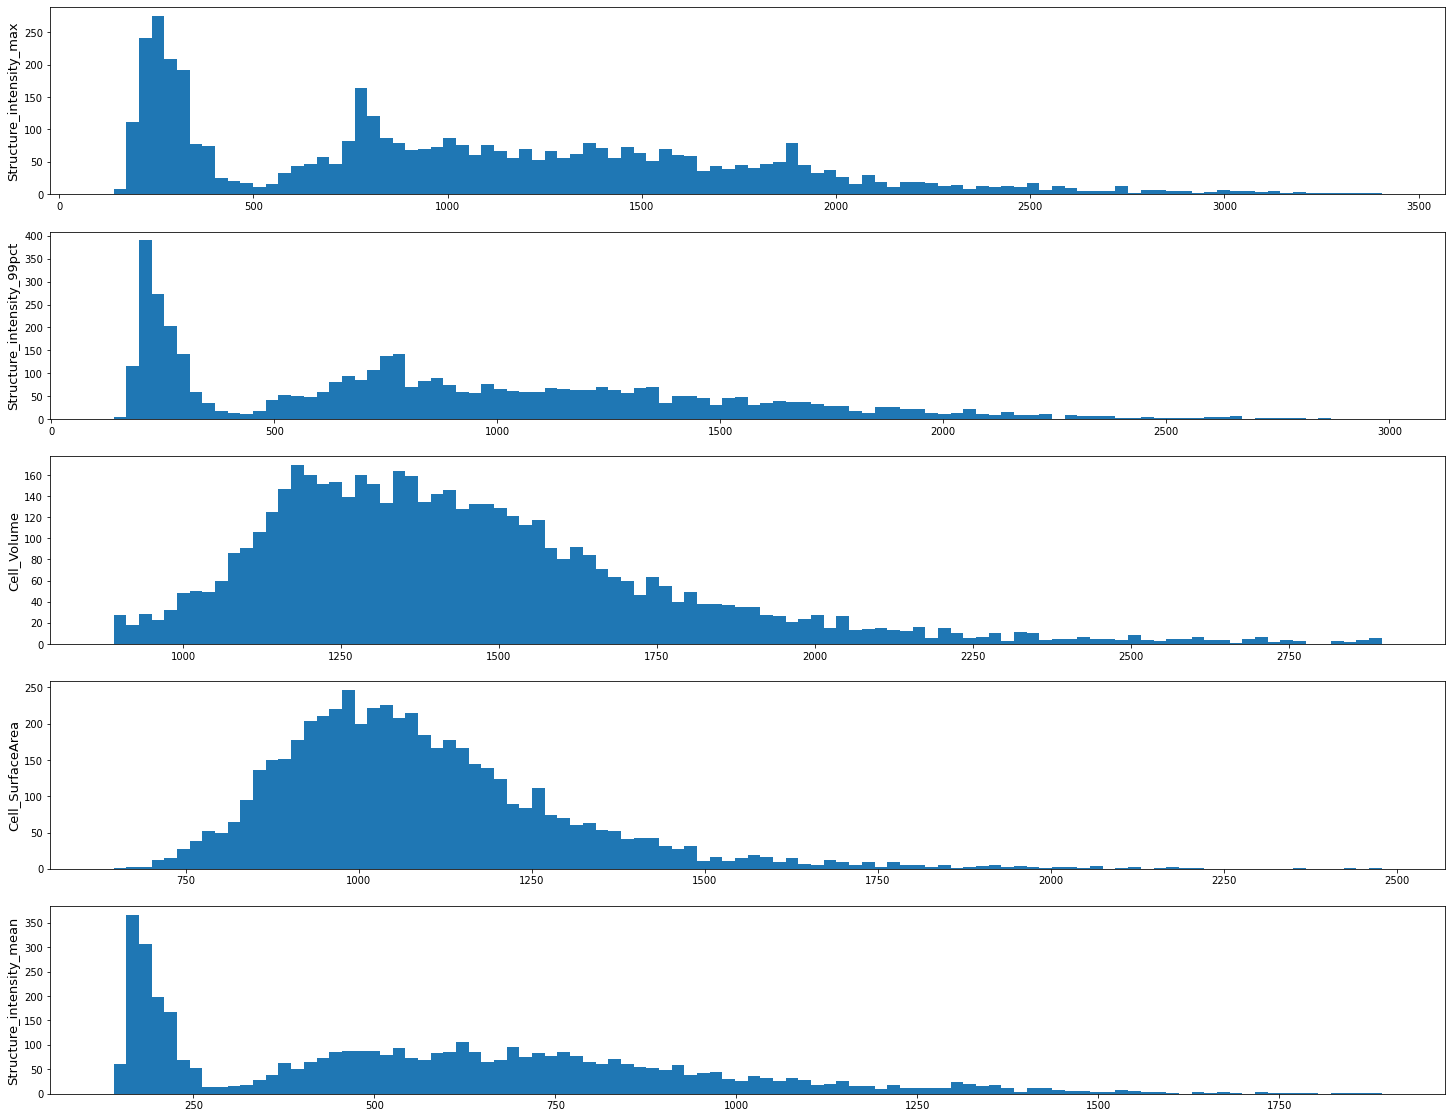

In [2]:
#################### Check shape distributions for extreme outliers before PCA ####################
import matplotlib.pyplot as plt
folder_fl = 'D:/Aaron/Data/Galvanotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'
info_fl = folder_fl + 'Processed_Data/'

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics.csv', index_col='cell')
# topfive = df.std().sort_values().index[-5:]
# df.shcoeffs_L0M0C


#add all of the other metrics from the single csv files
cellinfo = pd.DataFrame()
for i in df.index.to_list():
    tc = pd.read_csv(info_fl + i +'_cell_info.csv', index_col = 0)
    cellinfo = cellinfo.append(tc.loc[0])
# Add distance travelled per framerate to total frame
cellinfo.index = cellinfo.cell
df = df.merge(cellinfo.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_index = True, right_index = True)

metrics = df.std().sort_values(ascending = False).index[:5]
newdf = df[(df.Cell_Volume < 2900) & (df.Cell_Volume > 890)].copy()
newdf = newdf[newdf.Cell_SurfaceArea < 2800]
fig, axes = plt.subplots(len(metrics), 1, figsize=(25,20))#, sharex=True)
for i, ax in enumerate(axes):
    ax.hist(abs(newdf[metrics[i]]), 100) #, 30, (-2,2))
    ax.set_ylabel(metrics[i], fontsize = 13)

# newdf.to_csv(data_fl + 'Shape_Metrics_outliersremoved.csv')

In [4]:
# df.Cell_Volume.sort_values(ascending=True).head(60)
# df.Cell_Volume.std()*3.5
newdf.Cell_Volume.sort_values(ascending=False).head(60)

cell
20230727_488EGFP-CAAX_640SPY650-DNA_Random3_cell_10_frame_32       2897.050269
20230802_488EGFP-CAAX_640actin-halotag_Galv6_cell_6_frame_26       2896.189517
20230802_488EGFP-CAAX_640actin-halotag_Galv3_cell_32_frame_36      2895.435004
20230802_488EGFP-CAAX_640actin-halotag_Galv3_cell_9_frame_17       2892.526987
20230801_488EGFP-CAAX_640SPY650-DNA_Random3_cell_0_frame_34        2889.863967
20230802_488EGFP-CAAX_640actin-halotag_Random5_cell_12_frame_13    2881.217960
20230802_488EGFP-CAAX_640actin-halotag_Galv4_cell_12_frame_14      2872.523174
20230802_488EGFP-CAAX_640actin-halotag_Random3_cell_22_frame_26    2869.095883
20230802_488EGFP-CAAX_640actin-halotag_Random3_cell_2_frame_12     2867.601499
20230802_488EGFP-CAAX_640actin-halotag_Random2_cell_7_frame_32     2866.783561
20230801_488EGFP-CAAX_640SPY650-DNA_Random3_cell_6_frame_5         2848.166824
20230802_488EGFP-CAAX_640actin-halotag_Galv6_cell_6_frame_28       2838.381464
20230801_488EGFP-CAAX_640SPY650-DNA_Random4_cel

In [3]:
######### Perform PCA and divide cells into shape space bins ################

#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk

folder_fl = 'D:/Aaron/Data/Galvanotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'


#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_outliersremoved.csv', index_col='cell')


#exclude cells with centroids outside the mesh
excludes = pd.read_csv(data_fl + 'ListToExclude.csv', index_col=0)
exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
df = df.loc[[x for x in df.index if x not in exlist]]
coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]



# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1

df_trans = df_trans.drop(columns = 'Cell_Volume')



################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})

    
mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine metrics and digitized pcs
df_dig = df.merge(df_dig, left_index = True, right_index = True)
#save
df_dig.to_csv(data_fl+"Shape_Metrics_with_Digitized_PCs.csv")


########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

                
                
################## save PC meshes ##################
savedir = folder_fl + 'PC_Meshes/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(savedir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()

####### also save the pca object for later use ###########
pk.dump(pca, open(data_fl+"pca.pkl","wb"))



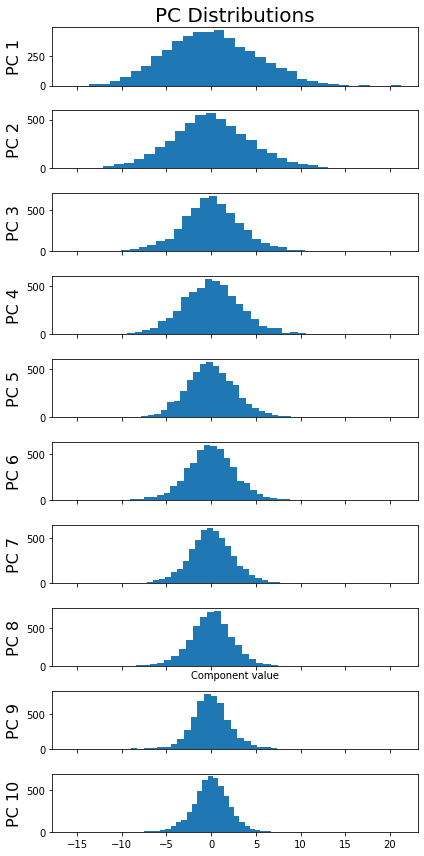

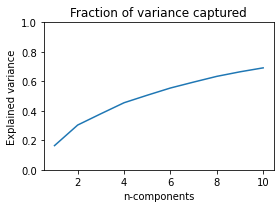

In [4]:
folder_fl = 'D:/Aaron/Data/Galvanotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'

########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(df_trans.iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(data_fl+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(data_fl + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = data_fl + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )

In [8]:
############## Average PILRs of entire dataset and split by migration mode #########################

from CustomFunctions import PILRagg
from aicscytoparam import cytoparam
import re
import vtk

folder_fl = 'D:/Aaron/Data/Chemotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'
pilr_fl = folder_fl + 'Processed_Data/PILRs/'
pilragg_fl = folder_fl + 'Processed_Data/avgPILRs/'
if not os.path.exists(pilragg_fl):
    os.makedirs(pilragg_fl)
    
#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
nisos = [1,63]
lmax = 10

#make tiny sphere for inner mesh
#create inner sphere
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(0.0, 0.0, 0.0)
sphereSource.SetRadius(nisos[0]/2)
# Make the surface smooth.
sphereSource.SetPhiResolution(100)
sphereSource.SetThetaResolution(100)
sphereSource.Update()
spherepoly = sphereSource.GetOutput()




#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')

migmod = []
for i, row in df.iterrows():
    if row.frame<41:
        migmod.append('Random')
    else:
        migmod.append('Chem_Directed')
df['Migration_Mode'] = migmod


pcdf = df[[x for x in df.columns.to_list() if 'bins' in x]]
for g in df.structure.unique():
    for i, p in enumerate(pcdf.columns.to_list()):
        for b in bins:
            allpilrs = []
            ######### do the averaging for each migration mode ########
            for m in df.Migration_Mode.unique():
                temp = pcdf[p][(df.structure==g) & (df.Migration_Mode==m)]
                num = temp[temp==b].index.to_list()
                if __name__ ==  '__main__':
                    # use multiprocessing to perform segmentation and x,y,z determination
                    pool = multiprocessing.Pool(processes=60)
                    results= []
                    for n in num:
                        pool.apply_async(PILRagg.read_parameterized_intensity, args=(pilr_fl + n + '_PILR.tif',), 
                                         callback=collect_results)
                    pool.close()
                    pool.join()
                pagg = np.array(results)
                allpilrs.append(pagg)
                del results
                #get average representation
                pagg_avg = np.mean(pagg, axis = 0)
                #normalize representations
                pagg_norm = PILRagg.normalize_representations(pagg)
                pagg_norm_avg = np.mean(pagg_norm, axis = 0)
                dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
                dims = ''.join(dims[::-1])
                OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_repsagg.tif', dim_order=dims)
                OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_repsagg_norm.tif', dim_order=dims)


                mesh_outer = PILRagg.read_vtk_polydata(folder_fl+'PC_Meshes/'+f'Cell_PC{i+1}_{b}_Cell.vtp')
                domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
                coords_param, _ = cytoparam.parameterize_image_coordinates(
                    seg_mem=(domain>0).astype(np.uint8),
                    seg_nuc=(domain>1).astype(np.uint8),
                    lmax=lmax,
                    nisos=nisos
                )

                morphed = cytoparam.morph_representation_on_shape(
                            img=domain,
                            param_img_coords=coords_param,
                            representation=pagg_avg)
                morphed = np.stack([domain, morphed])
                OmeTiffWriter.save(morphed, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_aggmorph.tif', dim_order='CZYX')
            ####### do all the averaging for the TOTAL data 
            pagg = np.concatenate(allpilrs)
            #get average representation
            pagg_avg = np.mean(pagg, axis = 0)
            #normalize representations
            pagg_norm = PILRagg.normalize_representations(pagg)
            pagg_norm_avg = np.mean(pagg_norm, axis = 0)
            dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
            dims = ''.join(dims[::-1])
            OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_alldata_{g}_repsagg.tif', dim_order=dims)
            OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_alldata_{g}_repsagg_norm.tif', dim_order=dims)


            mesh_outer = PILRagg.read_vtk_polydata(folder_fl+'PC_Meshes/'+f'Cell_PC{i+1}_{b}_Cell.vtp')
            domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
            coords_param, _ = cytoparam.parameterize_image_coordinates(
                seg_mem=(domain>0).astype(np.uint8),
                seg_nuc=(domain>1).astype(np.uint8),
                lmax=lmax,
                nisos=nisos
            )

            morphed = cytoparam.morph_representation_on_shape(
                        img=domain,
                        param_img_coords=coords_param,
                        representation=pagg_avg)
            morphed = np.stack([domain, morphed])
            OmeTiffWriter.save(morphed, pilragg_fl+p[:-1]+str(b)+f'_alldata_{g}_aggmorph.tif', dim_order='CZYX')

            print(f'Done with {g} {p} bin {b}')

Done with nucleus PC1_bins bin 1
Done with nucleus PC1_bins bin 2
Done with nucleus PC1_bins bin 3
Done with nucleus PC1_bins bin 4
Done with nucleus PC1_bins bin 5
Done with nucleus PC2_bins bin 1
Done with nucleus PC2_bins bin 2
Done with nucleus PC2_bins bin 3
Done with nucleus PC2_bins bin 4
Done with nucleus PC2_bins bin 5
Done with nucleus PC3_bins bin 1
Done with nucleus PC3_bins bin 2
Done with nucleus PC3_bins bin 3
Done with nucleus PC3_bins bin 4
Done with nucleus PC3_bins bin 5
Done with nucleus PC4_bins bin 1
Done with nucleus PC4_bins bin 2
Done with nucleus PC4_bins bin 3
Done with nucleus PC4_bins bin 4
Done with nucleus PC4_bins bin 5
Done with nucleus PC5_bins bin 1
Done with nucleus PC5_bins bin 2
Done with nucleus PC5_bins bin 3
Done with nucleus PC5_bins bin 4
Done with nucleus PC5_bins bin 5
Done with nucleus PC6_bins bin 1
Done with nucleus PC6_bins bin 2
Done with nucleus PC6_bins bin 3
Done with nucleus PC6_bins bin 4
Done with nucleus PC6_bins bin 5
Done with 

In [ ]:
############## Average PILRs of entire dataset and split by migration mode #########################

from CustomFunctions import PILRagg
from aicscytoparam import cytoparam
import re
import vtk

folder_fl = 'D:/Aaron/Data/Chemotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'
pilr_fl = folder_fl + 'Processed_Data/PILRs/'
pilragg_fl = folder_fl + 'Processed_Data/avgPILRs/'
if not os.path.exists(pilragg_fl):
    os.makedirs(pilragg_fl)
    
#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
nisos = [1,63]
lmax = 10

#make tiny sphere for inner mesh
#create inner sphere
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(0.0, 0.0, 0.0)
sphereSource.SetRadius(nisos[0]/2)
# Make the surface smooth.
sphereSource.SetPhiResolution(100)
sphereSource.SetThetaResolution(100)
sphereSource.Update()
spherepoly = sphereSource.GetOutput()




#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')



pcdf = df[[x for x in df.columns.to_list() if 'bins' in x]]
for g in df.structure.unique():
    for i, p in enumerate(pcdf.columns.to_list()):
        for b in bins:
            temp = pcdf[p][df.structure==g]
            num = temp[temp==b].index.to_list()
            if __name__ ==  '__main__':
                # use multiprocessing to perform segmentation and x,y,z determination
                pool = multiprocessing.Pool(processes=60)
                results= []
                for n in num:
                    pool.apply_async(PILRagg.read_parameterized_intensity, args=(pilr_fl + n + '_PILR.tif',), 
                                     callback=collect_results)
                pool.close()
                pool.join()
            pagg = np.array(results)
            del results
            #get average representation
            pagg_avg = np.mean(pagg, axis = 0)
            #normalize representations
            pagg_norm = PILRagg.normalize_representations(pagg)
            pagg_norm_avg = np.mean(pagg_norm, axis = 0)
            dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
            dims = ''.join(dims[::-1])
            OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_{g}_repsagg.tif', dim_order=dims)
            OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_{g}_repsagg_norm.tif', dim_order=dims)


            mesh_outer = PILRagg.read_vtk_polydata(folder_fl+'PC_Meshes/'+f'Cell_PC{i+1}_{b}_Cell.vtp')
            domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
            coords_param, _ = cytoparam.parameterize_image_coordinates(
                seg_mem=(domain>0).astype(np.uint8),
                seg_nuc=(domain>1).astype(np.uint8),
                lmax=lmax,
                nisos=nisos
            )

            morphed = cytoparam.morph_representation_on_shape(
                        img=domain,
                        param_img_coords=coords_param,
                        representation=pagg_avg)
            morphed = np.stack([domain, morphed])
            OmeTiffWriter.save(morphed, pilragg_fl+p[:-1]+str(b)+f'_{g}_aggmorph.tif', dim_order='CZYX')
            print(f'Done with {g} {p} bin {b}')

Done with nucleus PC PC1_bins bin 1
Done with nucleus PC PC1_bins bin 2
Done with nucleus PC PC1_bins bin 3
Done with nucleus PC PC1_bins bin 4
Done with nucleus PC PC1_bins bin 5
Done with nucleus PC PC2_bins bin 1
Done with nucleus PC PC2_bins bin 2
Done with nucleus PC PC2_bins bin 3
Done with nucleus PC PC2_bins bin 4
Done with nucleus PC PC2_bins bin 5
Done with nucleus PC PC3_bins bin 1
Done with nucleus PC PC3_bins bin 2
Done with nucleus PC PC3_bins bin 3
Done with nucleus PC PC3_bins bin 4
Done with nucleus PC PC3_bins bin 5
Done with nucleus PC PC4_bins bin 1
Done with nucleus PC PC4_bins bin 2
Done with nucleus PC PC4_bins bin 3
Done with nucleus PC PC4_bins bin 4
Done with nucleus PC PC4_bins bin 5
Done with nucleus PC PC5_bins bin 1
Done with nucleus PC PC5_bins bin 2
Done with nucleus PC PC5_bins bin 3
Done with nucleus PC PC5_bins bin 4
Done with nucleus PC PC5_bins bin 5
Done with nucleus PC PC6_bins bin 1
Done with nucleus PC PC6_bins bin 2
Done with nucleus PC PC6_bin

In [ ]:
pagg.shape

In [5]:
############## Stereotypy of entire dataset #########################

from CustomFunctions import PILRagg, stereotypyAvL
from aicscytoparam import cytoparam
import re
import itertools

    

folder_fl = 'D:/Aaron/Data/Chemotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'
pilr_fl = folder_fl + 'Processed_Data/PILRs/'
    
#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
nisos = [1,63]
lmax = 10
#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')

# genes = ['CORO1A','FMNL1','sgControl']
# gene_list = []
# for x in df.index.to_list(): 
#     gene_list.extend([g for g in genes if g in x])
# df['Gene'] = gene_list

# gcorr_frame = 
# for g in df.Gene.unique():
# g = df.Gene.unique()[0]
#     temp = df[df.Gene==g]
#     glist = temp.index.to_list()
glist = df.index.to_list()
# res = [(a, b) for idx, a in enumerate(glist) for b in glist[idx + 1:]]
res = list(itertools.combinations(glist,2))

start = 0
stop = 300
allresults = []
while stop<len(res):
    if __name__ ==  '__main__':
        # use multiprocessing to perform segmentation and x,y,z determination
        pool = multiprocessing.Pool(processes=60)
        results = []
        for r in res[start:stop]:
            strs = [df.structure[r[0]], df.structure[r[1]]]
            pool.apply_async(stereotypyAvL.correlate, args=(pilr_fl, r, strs,), 
                             callback=collect_results)
        pool.close()
        pool.join()

        allresults.extend(results)
        print(f'Done through #{stop}')
    start = stop + 1
    stop = stop + 300
    if stop>len(res):
        stop = len(res)+1
        
rframe = pd.DataFrame(allresults, columns=['CellId1', 'CellId2', 'Pearson', 'Structure1', 'Structure2'])
rframe.to_csv(data_fl + 'Structure_correlation_coeffs.csv')



In [ ]:
########### intracellular correlations by PC bins ###################
import seaborn as sns
import matplotlib.pyplot as plt

folder_fl = 'F:/Screen_Mutants/Data/'
data_fl = folder_fl + 'Data_and_Figs/'

rframe = pd.read_csv(data_fl + 'Actin_correlation_coeffs.csv', index_col=0)
Shape_Metrics = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')

PCbins = [x for x in Shape_Metrics.columns.to_list() if 'bin' in x]
binnum = np.sort(Shape_Metrics[PCbins[0]].unique())

corravg = []

for p in PCbins:
# p = PCbins[0]
    for b in binnum:
# b = binnum[0]
        binlist = Shape_Metrics[Shape_Metrics[p]==b].index.to_list()
        combos = [(a, b) for idx, a in enumerate(binlist) for b in binlist[idx + 1:]]
        combos = pd.DataFrame(combos, columns = ['CellId1', 'CellId2'])
        common = pd.merge(rframe, combos, on=['CellId1', 'CellId2'], how='inner')

        corravg.append([p.split('_')[0],b,common.Pearson.mean()])

corravg = pd.DataFrame(corravg, columns = ['PC', 'bin', 'correlation'])


ax = sns.heatmap(corravg.pivot(index='PC', columns='bin', values='correlation'), vmin=-1, vmax=1)
# plt.savefig(data_fl + 'PC correlation with actin distibution.png', bbox_inches='tight')


In [ ]:
############### intracellular correlation by experiment group ######################

folder_fl = 'F:/Screen_Mutants/Data/'
data_fl = folder_fl + 'Data_and_Figs/'

rframe = pd.read_csv(data_fl + 'Actin_correlation_coeffs.csv', index_col=0)

genes = ['CORO1A','FMNL1','sgControl']
pairlist = []
for g in range(len(genes)):
    for gg in genes[g:]:
        pairlist.append([genes[g],gg])
pairlist
corrlist = []
for p in pairlist:
# p = pairlist[0]
    corr = rframe[rframe.CellId1.str.contains(p[0]) & rframe.CellId2.str.contains(p[1])].Pearson.mean()
    corrlist.append([p[0],p[1],corr])
corrlist

corravg = pd.DataFrame(corrlist, columns = ['gene', 'genecorr', 'correlation'])


ax = sns.heatmap(corravg.pivot(index='gene', columns='genecorr', values='correlation'), vmin=-1, vmax=1)
plt.savefig(data_fl + 'gene correlation with actin distibution.png', bbox_inches='tight')